In [1]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram, plot_state_city, plot_bloch_multivector
from math import pi


# создадим квантовую схему из двух кубитов
sim = Aer.get_backend('aer_simulator')
circuit = QuantumCircuit(2,2) # 2, 2 - число квантовых и реальных битов соотвественно


In [2]:
# добавляем гейт Адамара - он переводит первый кубит из состяния |0> в состяние |+> (50% |10> 50% |00>) 
circuit.h(0) # <- 0 - номер кубита


# добавляем гейт CX (CNOT) - он инвертирует состояние первого кубита, если нулевой = 1
circuit.cx(0, 1)
# состояния кубитов: 50% |00> -> |00> 50 % |10> -> |11>

In [3]:
circuit.measure([0, 1], [0, 1]) # <- измерить кубиты индексами [0, 1] (с помощью преобразований паули по z) в биты индексами [0, 1]
circuit.save_statevector()

In [4]:
# можно отрисовать получившуюся схему символами
circuit.draw()

┌───┐     ┌─┐    statevector 
q_0: ┤ H ├──■──┤M├─────────░──────
     └───┘┌─┴─┐└╥┘┌─┐      ░      
q_1: ─────┤ X ├─╫─┤M├──────░──────
          └───┘ ║ └╥┘      ░      
c: 2/═══════════╩══╩══════════════
                0  1

In [5]:
# импортируем симулятор КК
from qiskit_aer import AerSimulator


# транспайлим под симулятор КК
simulator = AerSimulator()
circuit = transpile(circuit, simulator)

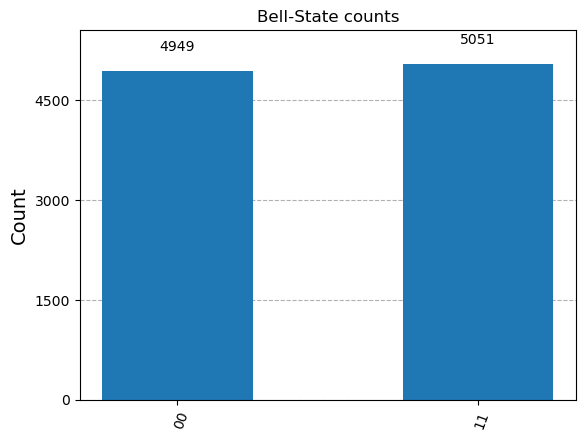

In [6]:
result = simulator.run(circuit, shots=10000).result()
counts = result.get_counts(circuit)
plot_histogram(counts, title='Bell-State counts')

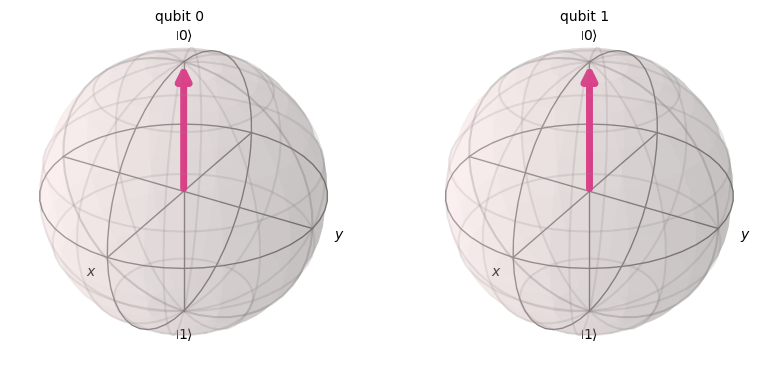

In [7]:
statevector = result.get_statevector()
plot_bloch_multivector(statevector)

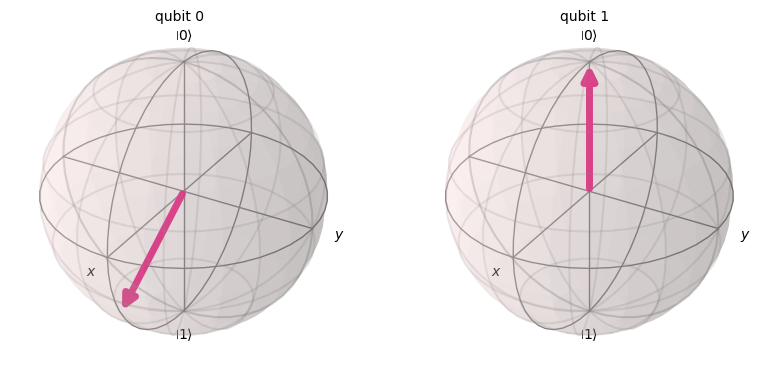

In [8]:
circuit = QuantumCircuit(2,2)
circuit.ry(45, 0)
circuit.x(0) # Задаем первому кубиту  состяние "+"
#circuit.cx(0, 1) # вращаем нулевой кубит вокруг "y" на 45 градусов
circuit.save_statevector()

simulator = AerSimulator()
circuit = transpile(circuit, simulator)

result = simulator.run(circuit).result()

statevector = result.get_statevector()
plot_bloch_multivector(statevector)
     

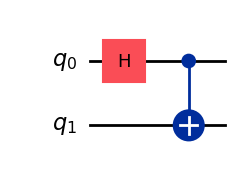

In [9]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator

# Создаем новую схему из двух кубитов
qc = QuantumCircuit(2)

# Добавляем оператор Адамара на нулевой кубит
qc.h(0)


# Добавляем управляемый X-гейт на первый кубит, с управлением через нулевой
qc.cx(0, 1)
# Отрисовываем схему через Matplotlib
# Если убрать аргумент 'mpl' - будет отрисовка текстовыми символами
qc.draw("mpl")



In [10]:
# Задаем шесть измеряемых величин

observables_labels = ["IZ", "IX", "ZI", "XI", "ZZ", "XX"] # показывает корреляцию между двумя измерениями
observables = [SparsePauliOp(label) for label in observables_labels]

simulator = AerSimulator()
estimator = Estimator(simulator)
estimator.options.resilience_level = 1
estimator.options.default_shots = 5000


# Один PUB c одной схемой на запуск, у схемы несколько измеряемых величин
job = estimator.run([(qc, observables)])

print(f">>> Job ID: {job.job_id()}")

job_result = job.result()

# результат одного запуска с 6 измеряемыми величинами
pub_result = job.result()[0]

>>> Job ID: 87025f26-19bb-4099-b923-e26053d4de9f


c:\Users\DeOwl\anaconda3\envs\qiskit\Lib\site-packages\qiskit_ibm_runtime\fake_provider\local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


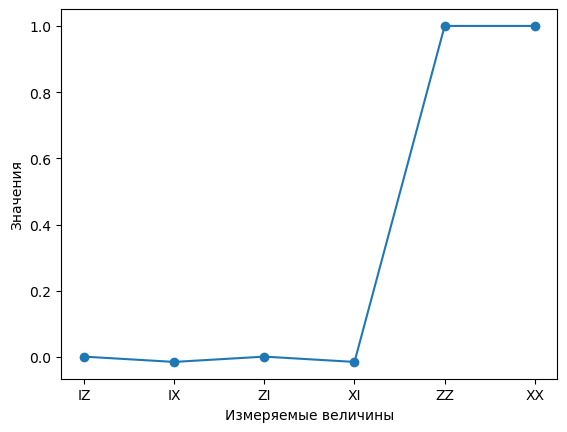

In [11]:
from matplotlib import pyplot as plt

values = pub_result.data.evs

errors = pub_result.data.stds

plt.plot(observables_labels, values, "-o")
plt.xlabel("Измеряемые величины")
plt.ylabel("Значения")
plt.show()

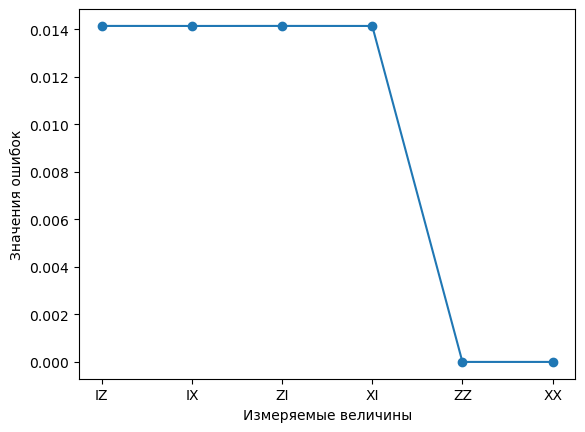

In [12]:
plt.plot(observables_labels, errors, "-o")
plt.xlabel("Измеряемые величины")
plt.ylabel("Значения ошибок")
plt.show()
     

In [13]:
def balanced_black_box(c):
  c.cx(0, 2)
  c.cx(1, 2)
  return c

def constant_black_box(c):
  return c

In [14]:
c = QuantumCircuit(3,2)
c.x(2)
c.barrier()
c.h(0)
c.h(1)
c.h(2)
c.barrier()
c = balanced_black_box(c)
# c = constant_black_box(c)
c.barrier()
c.h(0)
c.h(1)
c.h(2)
c.measure([0,1], [0,1])
c.draw()

░ ┌───┐ ░            ░ ┌───┐┌─┐   
q_0: ──────░─┤ H ├─░───■────────░─┤ H ├┤M├───
           ░ ├───┤ ░   │        ░ ├───┤└╥┘┌─┐
q_1: ──────░─┤ H ├─░───┼────■───░─┤ H ├─╫─┤M├
     ┌───┐ ░ ├───┤ ░ ┌─┴─┐┌─┴─┐ ░ ├───┤ ║ └╥┘
q_2: ┤ X ├─░─┤ H ├─░─┤ X ├┤ X ├─░─┤ H ├─╫──╫─
     └───┘ ░ └───┘ ░ └───┘└───┘ ░ └───┘ ║  ║ 
c: 2/═══════════════════════════════════╩══╩═
                                        0  1

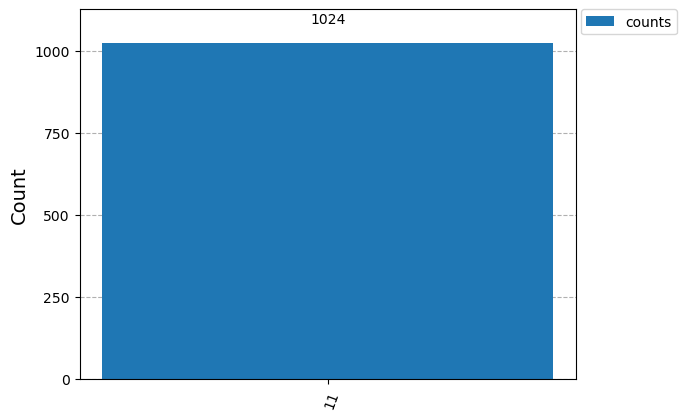

In [15]:

c = transpile(c, simulator)
result = simulator.run(c).result()

new_counts = result.get_counts()
plot_histogram([new_counts], legend=['counts'])

In [16]:
c = QuantumCircuit(3,2)
c.x(2)
c.barrier()
c.h(0)
c.h(1)
c.h(2)
c.barrier()
#c = balanced_black_box(c)
c = constant_black_box(c)
c.barrier()
c.h(0)
c.h(1)
c.h(2)
c.measure([0,1], [0,1])
c.draw()

░ ┌───┐ ░  ░ ┌───┐┌─┐   
q_0: ──────░─┤ H ├─░──░─┤ H ├┤M├───
           ░ ├───┤ ░  ░ ├───┤└╥┘┌─┐
q_1: ──────░─┤ H ├─░──░─┤ H ├─╫─┤M├
     ┌───┐ ░ ├───┤ ░  ░ ├───┤ ║ └╥┘
q_2: ┤ X ├─░─┤ H ├─░──░─┤ H ├─╫──╫─
     └───┘ ░ └───┘ ░  ░ └───┘ ║  ║ 
c: 2/═════════════════════════╩══╩═
                              0  1

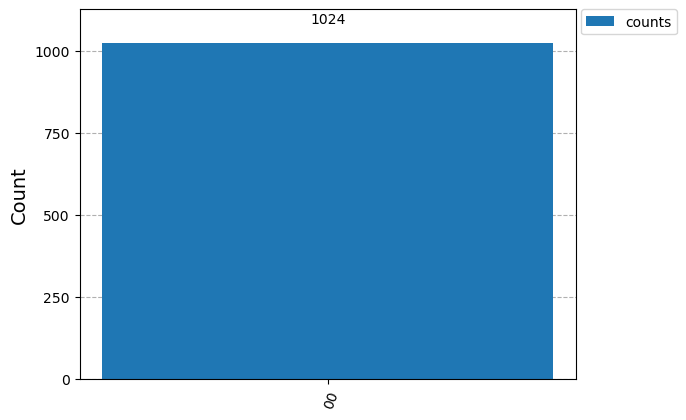

In [17]:
c = transpile(c, simulator)
result = simulator.run(c).result()

new_counts = result.get_counts()
plot_histogram([new_counts], legend=['counts'])

In [18]:
from qiskit import QuantumCircuit, qasm2


circuit = QuantumCircuit(2, 2)
circuit.h(0)
circuit.cx(0, 1)
circuit.measure([0, 1], [0, 1])

# экспортируем в строку
program = qasm2.dumps(circuit)

# экспортируем в файл
qasm2.dump(circuit, "my_file.qasm")
print(program)

OPENQASM 2.0;
include "qelib1.inc";
qreg q[2];
creg c[2];
h q[0];
cx q[0],q[1];
measure q[0] -> c[0];
measure q[1] -> c[1];


In [19]:

import qiskit.qasm2

circuit = qiskit.qasm2.loads(program, include_path=('.',), custom_instructions=(), custom_classical=(), strict=False)
circuit.draw()

┌───┐     ┌─┐   
q_0: ┤ H ├──■──┤M├───
     └───┘┌─┴─┐└╥┘┌─┐
q_1: ─────┤ X ├─╫─┤M├
          └───┘ ║ └╥┘
c: 2/═══════════╩══╩═
                0  1

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.optimizers import COBYLA, L_BFGS_B
from qiskit_machine_learning.utils import algorithm_globals

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.circuit.library import QNNCircuit
from qiskit.primitives import StatevectorEstimator as Estimator

algorithm_globals.random_seed = 42

In [21]:
num_samples = 20
eps = 0.2
lb, ub = -np.pi, np.pi
X_ = np.linspace(lb, ub, num=50).reshape(50, 1)
f = lambda x: np.sin(x)

X = (ub - lb) * algorithm_globals.random.random([num_samples, 1]) + lb
y = f(X[:, 0]) + eps * (2 * algorithm_globals.random.random(num_samples) - 1)

In [22]:
estimator = Estimator()
objective_func_vals = []

def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [23]:

param_x = Parameter("x")
feature_map = QuantumCircuit(1, name="fm")
feature_map.ry(param_x, 0)

param_y = Parameter("y")
ansatz = QuantumCircuit(1, name="vf")
ansatz.ry(param_y, 0)

In [24]:
vqr = VQR(
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=L_BFGS_B(maxiter=5),
    callback=callback_graph,
    estimator=estimator,
)

No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


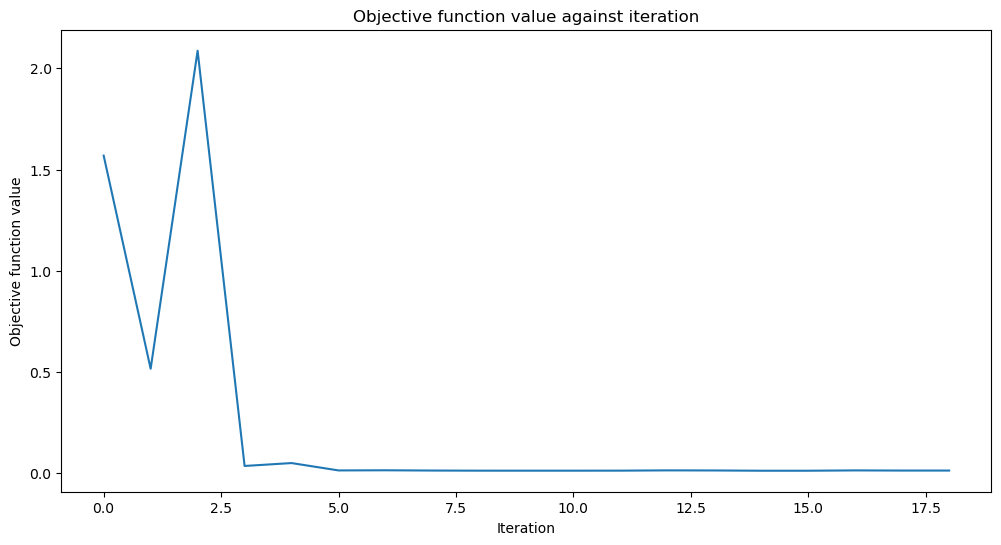

0.9699396873833361

In [25]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit regressor
vqr.fit(X, y)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score result
vqr.score(X, y)

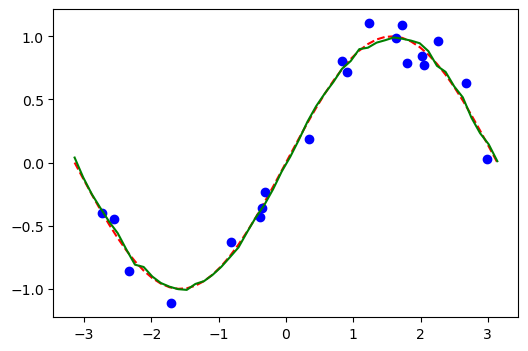

In [26]:
# plot target function
plt.plot(X_, f(X_), "r--")

# plot data
plt.plot(X, y, "bo")

# plot fitted line
y_ = vqr.predict(X_)
plt.plot(X_, y_, "g-")
plt.show()

## Импульсы

C:\Users\DeOwl\AppData\Local\Temp\ipykernel_16212\2140136910.py:21: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="sx-sy schedule") as sxp:
C:\Users\DeOwl\AppData\Local\Temp\ipykernel_16212\2140136910.py:22: DeprecationWarning: The class ``qiskit.pulse.channels.Channel`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.play(pulse.Drag(duration, amp, sig / dt, beta), pulse.DriveChannel(0))
C:\Users\DeOwl\AppData\Local\Temp\ipykernel_16212\2140136910.py:22: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit

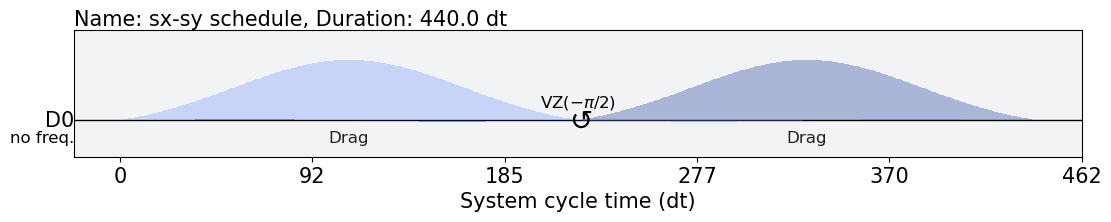

In [27]:

import numpy as np
import qiskit.pulse as pulse

# Strength of the Rabi-rate in GHz.
# Мощность воздействия нашего сигнала, ГГц
r = 0.1

# Частота кубита, ГГц
w = 5.

# Время обновления бэкенда, нс
dt = 1 / 4.5

# Задаем гауссову огибающую функцию, чтобы приблизительно смоделировать SX-гейт
amp = 1. / 1.75
sig = 0.6985/r/amp
T = 4*sig
duration = int(T / dt)
beta = 2.0

with pulse.build(name="sx-sy schedule") as sxp:
    pulse.play(pulse.Drag(duration, amp, sig / dt, beta), pulse.DriveChannel(0))
    pulse.shift_phase(np.pi/2, pulse.DriveChannel(0))
    pulse.play(pulse.Drag(duration, amp, sig / dt, beta), pulse.DriveChannel(0))

sxp.draw()

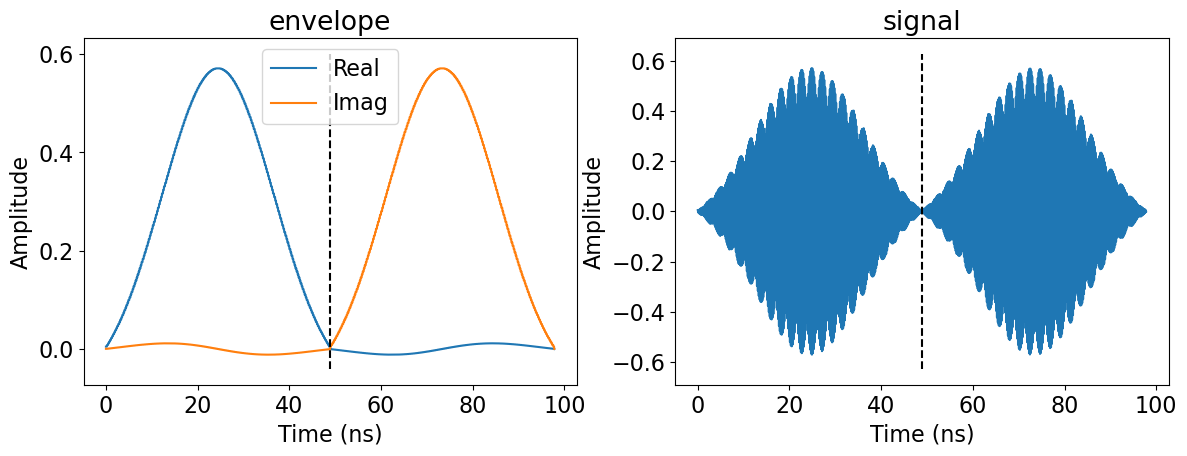

In [28]:
from matplotlib import pyplot as plt
from qiskit_dynamics.pulse import InstructionToSignals

plt.rcParams["font.size"] = 16

converter = InstructionToSignals(dt, carriers={"d0": w})

signals = converter.get_signals(sxp)
fig, axs = plt.subplots(1, 2, figsize=(14, 4.5))
for ax, title in zip(axs, ["envelope", "signal"]):
    signals[0].draw(0, 2*T, 2000, title, axis=ax)
    ax.set_xlabel("Time (ns)")
    ax.set_ylabel("Amplitude")
    ax.set_title(title)
    ax.vlines(T, ax.get_ylim()[0], ax.get_ylim()[1], "k", linestyle="dashed")

In [29]:
from qiskit.quantum_info.operators import Operator
from qiskit_dynamics import Solver

X = Operator.from_label('X')
Z = Operator.from_label('Z')

drift = 2 * np.pi * w * Z/2
operators = [2 * np.pi * r * X/2]

hamiltonian_solver = Solver(
    static_hamiltonian=drift,
    hamiltonian_operators=operators,
    rotating_frame=drift,
    rwa_cutoff_freq=2 * 5.0,
    hamiltonian_channels=['d0'],
    channel_carrier_freqs={'d0': w},
    dt=dt
)

In [30]:
from qiskit.quantum_info.states import Statevector

# Start the qubit in its ground state.
y0 = Statevector([1., 0.])

%time sol = hamiltonian_solver.solve(t_span=[0., 2*T], y0=y0, signals=sxp, atol=1e-8, rtol=1e-8)

CPU times: total: 14.1 s
Wall time: 14 s


In [31]:
def plot_populations(sol):
    pop0 = [psi.probabilities()[0] for psi in sol.y]
    pop1 = [psi.probabilities()[1] for psi in sol.y]

    fig = plt.figure(figsize=(8, 5))
    plt.plot(sol.t, pop0, lw=3, label="Вероятность |0>")
    plt.plot(sol.t, pop1, lw=3, label="Вероятность |1>")
    plt.xlabel("Время (нс)")
    plt.ylabel("Вероятность")
    plt.legend(frameon=False)
    plt.ylim([0, 1.05])
    plt.xlim([0, 2*T])
    plt.vlines(T, 0, 1.05, "k", linestyle="dashed")

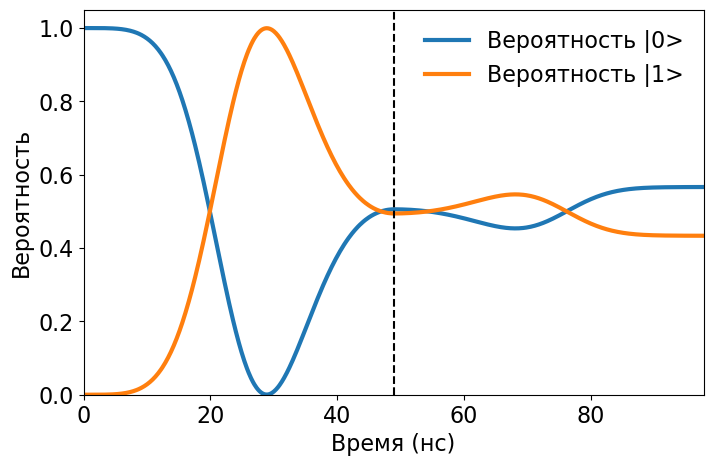

In [32]:

plot_populations(sol)